# Introduction
Nous allons ici développer un algorithme de Machine Learning destiné à assigner automatiquement plusieurs tags pertinents à une question posée sur le célébre site Stack overflow.     
Ce programme s'adresse principalement aux nouveaux utilisateurs, afin de leur suggérer quelques tags relatifs à la question qu'ils souhaitent poser.

### Jeu de données
Les données ont été captées via l'outil d’export de données "stackexchange" explorer, qui recense un grand nombre de données authentiques de la plateforme d’entraide.     

Dans ce Notebook, nous réaliserons un nettoyage des données ainsi qu'une analyse exploratoire. 
Un second notebook concernera les approches supervisées et non supervisées pour traiter la création de Tags à partir des données textuelles.     


In [1]:
# Install package for PEP8 verification
!pip install pycodestyle
!pip install --index-url https://test.pypi.org/simple/ nbpep8

Looking in indexes: https://test.pypi.org/simple/


In [2]:
# Install Beautifulsoup4
!pip install beautifulsoup4

In [3]:
# Install langdetect
!pip install langdetect

In [4]:
# Install spaCy
!pip install spacy

In [5]:
# Install wordcloud
!pip install wordcloud

In [6]:
# Import Python libraries
import os
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from langdetect import detect
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy
from spacy import displacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import KBinsDiscretizer

# Library for PEP8 standard
from nbpep8.nbpep8 import pep8

In [7]:
plt.style.use('seaborn-whitegrid')
sns.set_style("whitegrid")

In [8]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]   

True

## Importation et description des données

In [9]:
# Importing the database 

df = pd.read_csv("Questions.csv", encoding="ISO-8859-1")

In [10]:
df.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [11]:
tags = pd.read_csv("Tags.csv", encoding="ISO-8859-1", dtype={'Tag': str})

In [12]:
tags.head(5)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [14]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [15]:
tags['Tag'] = tags['Tag'].astype(str)

In [16]:
grouped_tags = tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))

In [17]:
grouped_tags.head(5)

Id
80                            flex actionscript-3 air
90       svn tortoisesvn branch branching-and-merging
120                               sql asp.net sitemap
180    algorithm language-agnostic colors color-space
260           c# .net scripting compiler-construction
Name: Tag, dtype: object

In [18]:
grouped_tags.reset_index()

,Id,Tag
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction
...,...,...
1264211,40143210,php .htaccess
1264212,40143300,google-bigquery
1264213,40143340,android android-studio
1264214,40143360,javascript vue.js


In [19]:
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})

In [20]:
grouped_tags_final.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


In [21]:
df.drop(columns=['OwnerUserId', 'ClosedDate'], inplace=True)

In [22]:
data = df.copy()

In [23]:
data.head(5)

,Id,CreationDate,Score,Title,Body
0,80,2008-08-01T13:57:07Z,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,2008-08-01T14:41:24Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,2008-08-01T15:50:08Z,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2008-08-01T18:42:19Z,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,2008-08-01T23:22:08Z,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [24]:
data.shape

(1264216, 5)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Id            1264216 non-null  int64 
 1   CreationDate  1264216 non-null  object
 2   Score         1264216 non-null  int64 
 3   Title         1264216 non-null  object
 4   Body          1264216 non-null  object
dtypes: int64(2), object(3)
memory usage: 48.2+ MB


In [26]:
data = data.merge(grouped_tags_final, on='Id')

In [27]:
data.head(3)

,Id,CreationDate,Score,Title,Body,Tags
0,80,2008-08-01T13:57:07Z,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,2008-08-01T14:41:24Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,2008-08-01T15:50:08Z,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap


In [28]:
data = data[data['Score'] > 5]

Text(0.5, 1.0, 'Ratio of missing values per columns')

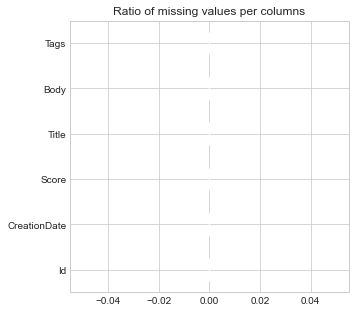

In [29]:
plt.figure(figsize=(5, 5))
data.isnull().mean(axis=0).plot.barh()
plt.title("Ratio of missing values per columns")

In [30]:
print('Dupplicate entries: {}'.format(data.duplicated().sum()))
data.drop_duplicates(inplace = True)

Dupplicate entries: 0


In [31]:
data.set_index('Id', inplace=True)

In [32]:
data.head(3)

,CreationDate,Score,Title,Body,Tags
Id,,,,,
80,2008-08-01T13:57:07Z,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
90,2008-08-01T14:41:24Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
120,2008-08-01T15:50:08Z,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap


## Exploration

Dans un premier temps, nous allons regarder l'évolution du nombre de questions par année dans notre jeu de données.

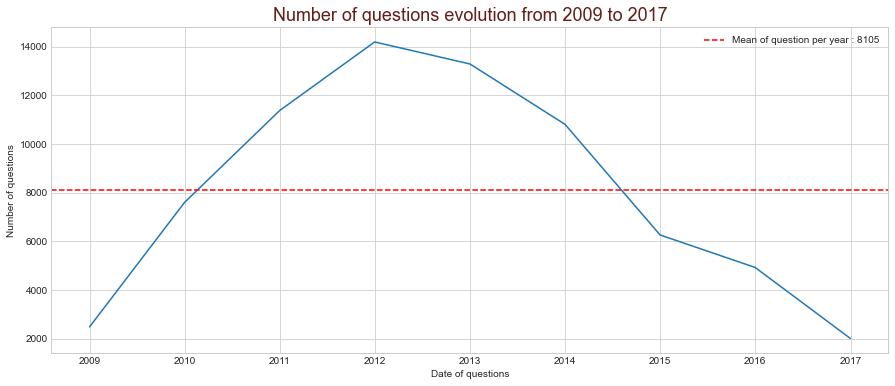

In [33]:
# Convert CreationDate to datetime format
data['CreationDate'] = pd.to_datetime(data['CreationDate'])

# Grouper with 1 year delta
post_year = data.groupby(pd.Grouper(key='CreationDate',
                                    freq='1Y')).agg({'Title': 'count'})

# Plot evolution
fig = plt.figure(figsize=(15,6))
sns.lineplot(data=post_year, x=post_year.index, y='Title')
plt.axhline(post_year.Title.mean(), 
            color="r", linestyle='--',
            label="Mean of question per year : {:04d}"\
                   .format(int(post_year.Title.mean())))
plt.xlabel("Date of questions")
plt.ylabel("Number of questions")
plt.title("Number of questions evolution from 2009 to 2017",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

On peut voir que pour nos critères de sélection, le nombre de questions posées a tendance à diminuer depuis 2014.

Nous allons maintenant observer la longeur des différents titres  :

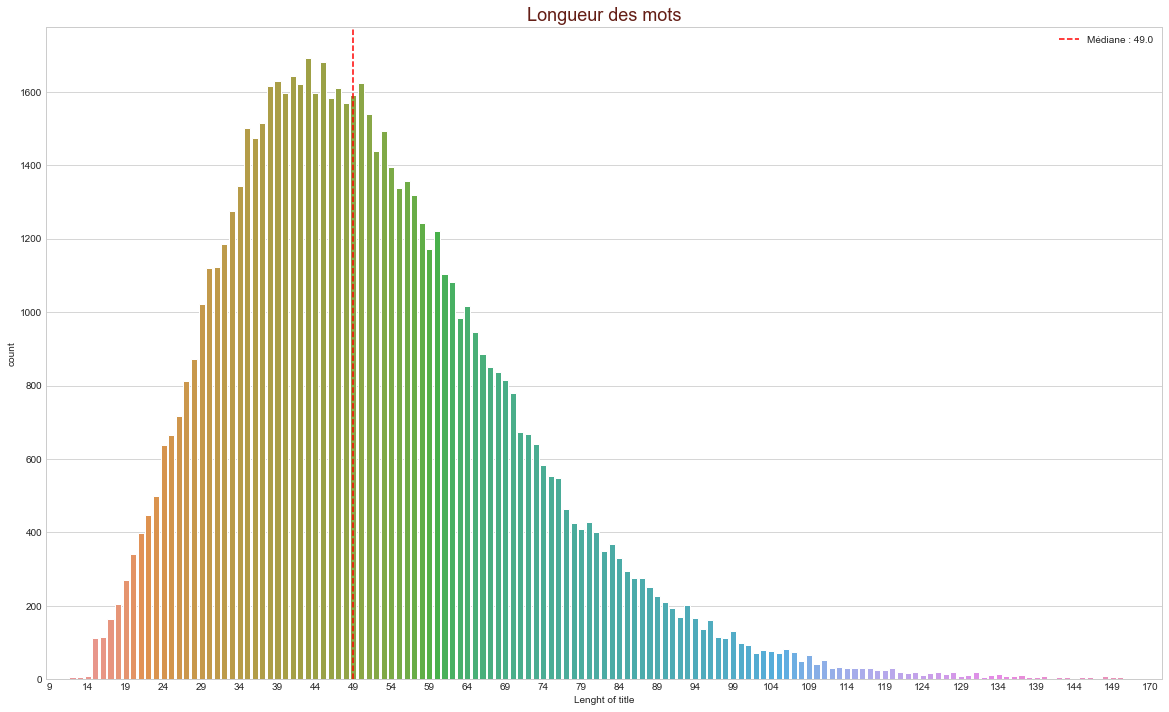

In [34]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=data.Title.str.len())
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))
plt.axvline(data.Title.str.len().median() - data.Title.str.len().min(),
            color="r", linestyle='--',
            label="Médiane : "+str(data.Title.str.len().median()))
ax.set_xlabel("Lenght of title")
plt.title("Longueur des mots",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

Nous allons également représenter la répartition des longueurs de la variable 'Body' (les corps de texte des questions). L'étendue étant très importante, nous allons dans un premier temps discrétiser ces longueur pour ne pas surcharger les temps de calculs de projection graphique :

In [35]:
# Discretizer for Body characters lenght
X = pd.DataFrame(data.Body.str.len())

# Sklearn discretizer with 200 bins
discretizer = KBinsDiscretizer(n_bins=200,
                               encode='ordinal',
                               strategy='uniform')
body_lenght = discretizer.fit_transform(X)
body_lenght = discretizer.inverse_transform(body_lenght)
body_lenght = pd.Series(body_lenght.reshape(-1))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


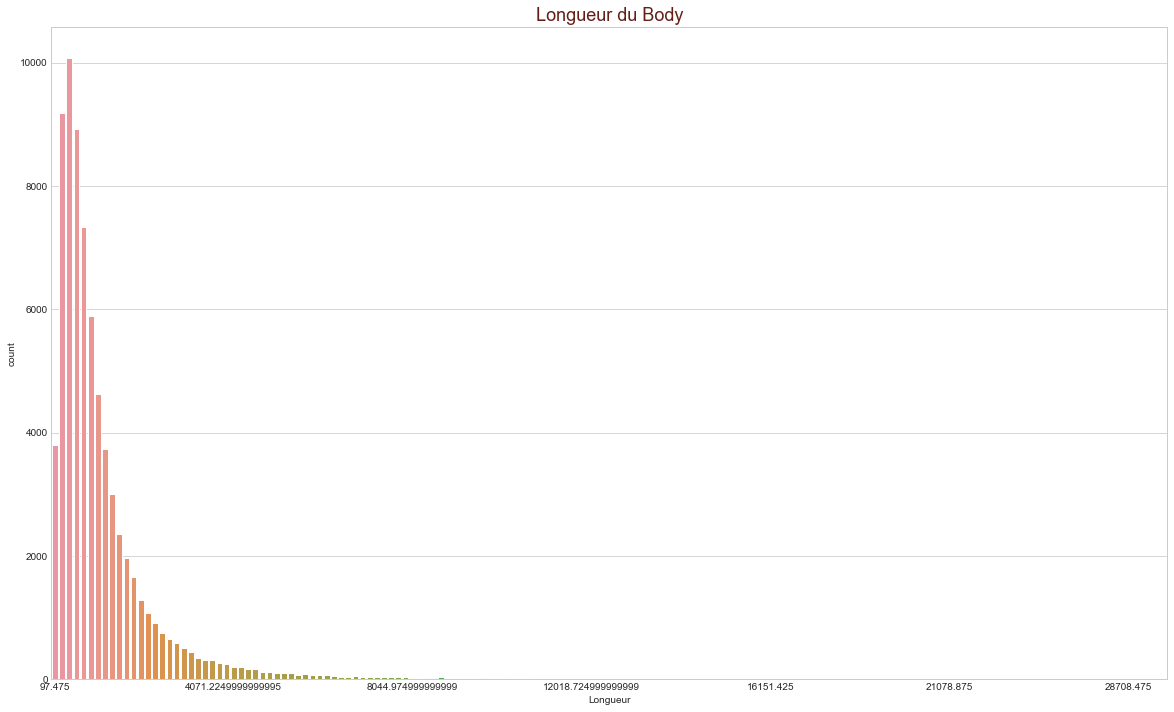

In [36]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=body_lenght)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 25))
ax.set_xlabel("Longueur")
plt.title("Longueur du Body",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

On remarque que la majeur partie des questions compte moins de 4000 caractères (balises HTML compris) mais certains posts dépassent les 10 000 caractères. Nous allons filtrer notre jeu de données pour conserver uniquement les questions de moins de 4 000 caractères afin de ne pas compliquer le NLP plus que nécessaire.

In [37]:
# Filter data on body lenght
data = data[data.Body.str.len() < 4000]
data.shape

(70271, 5)

### Analyse des Tags
Nous allons faire une rapide analyse exploratoire sur les tags du jeu de données.

In [38]:
data['Tags'].head(3)

Id
80                          flex actionscript-3 air
90     svn tortoisesvn branch branching-and-merging
120                             sql asp.net sitemap
Name: Tags, dtype: object

Nous allons modifier les séparateurs de Tags pour favoriser les extractions :

In [39]:
# Replace open and close balise between tags
data['Tags'] = data['Tags'].str.translate(str.maketrans({' ': ','}))

# Delete last "," for each row
data['Tags'] = data['Tags'].str[:-1]
data['Tags'].head(3)

Id
80                          flex,actionscript-3,ai
90     svn,tortoisesvn,branch,branching-and-mergin
120                             sql,asp.net,sitema
Name: Tags, dtype: object

Les tags contenus dans la variable Tags sont ensuite splités et ajoutés dans une liste pour ensuite les classer :

In [40]:
def count_split_tags(df, column, separator):
    """This function allows you to split the different words contained
    in a Pandas Series cell and to inject them separately into a list.
    This makes it possible, for example, to count the occurrences of words.

    Parameters
    ----------------------------------------
    df : Pandas Dataframe
        Dataframe to use.
    column : string
        Column of the dataframe to use
    separator : string
        Separator character for str.split.
    ----------------------------------------
    """
    list_words = []
    for word in df[column].str.split(separator):
        list_words.extend(word)
    df_list_words = pd.DataFrame(list_words, columns=["Tag"])
    df_list_words = df_list_words.groupby("Tag")\
        .agg(tag_count=pd.NamedAgg(column="Tag", aggfunc="count"))
    df_list_words.sort_values("tag_count", ascending=False, inplace=True)
    return df_list_words

In [41]:
tags_list = count_split_tags(df=data, column='Tags', separator=',')
print("Le jeu de données compte {} tags.".format(tags_list.shape[0]))

Le jeu de données compte 19144 tags.


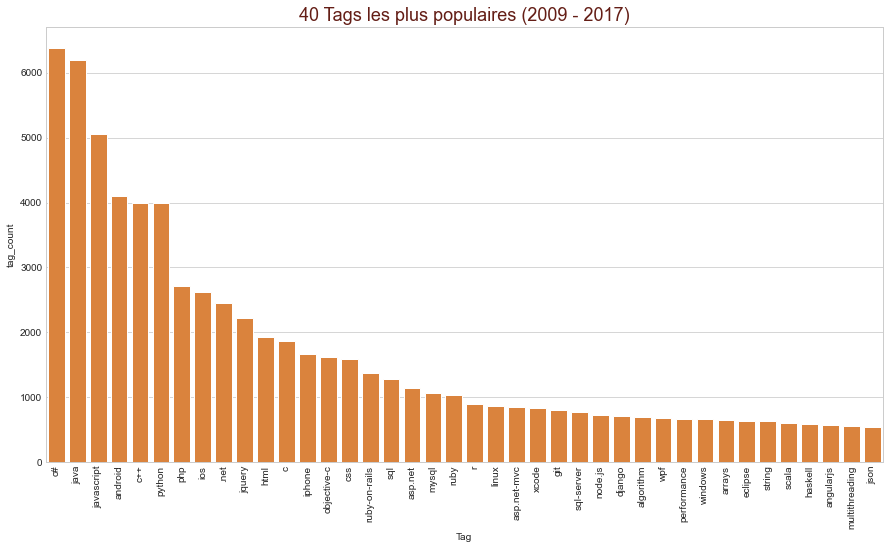

In [42]:
# Plot the results of splits
fig = plt.figure(figsize=(15, 8))
sns.barplot(data=tags_list.iloc[0:40, :],
            x=tags_list.iloc[0:40, :].index,
            y="tag_count", color="#f48023")
plt.xticks(rotation=90)
plt.title("40 Tags les plus populaires (2009 - 2017)",
          fontsize=18, color="#641E16")
plt.show()

Nous pouvons également visualiser les 500 premières catégories dans un nuage de mots :

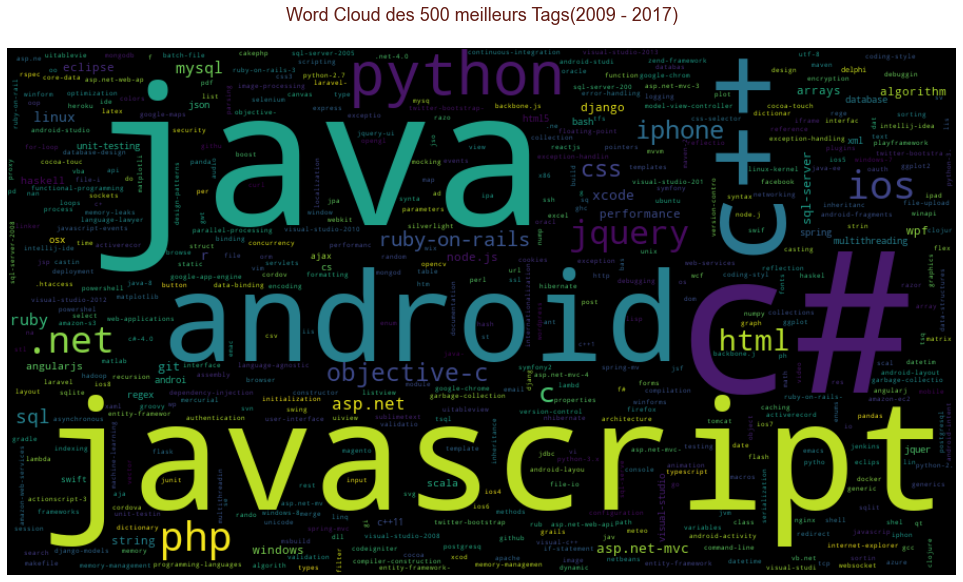

In [43]:
# Plot word cloud with tags_list (frequencies)
fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(tags_list.to_dict()['tag_count'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud des 500 meilleurs Tags(2009 - 2017)\n",
          fontsize=18, color="#641E16")
plt.show()

Il peut être intéressant de regarder si ces tags populaires ont évolués au fil du temps. Prenons par exemple les années 2009, 2012 et 2016 pour vérifier.

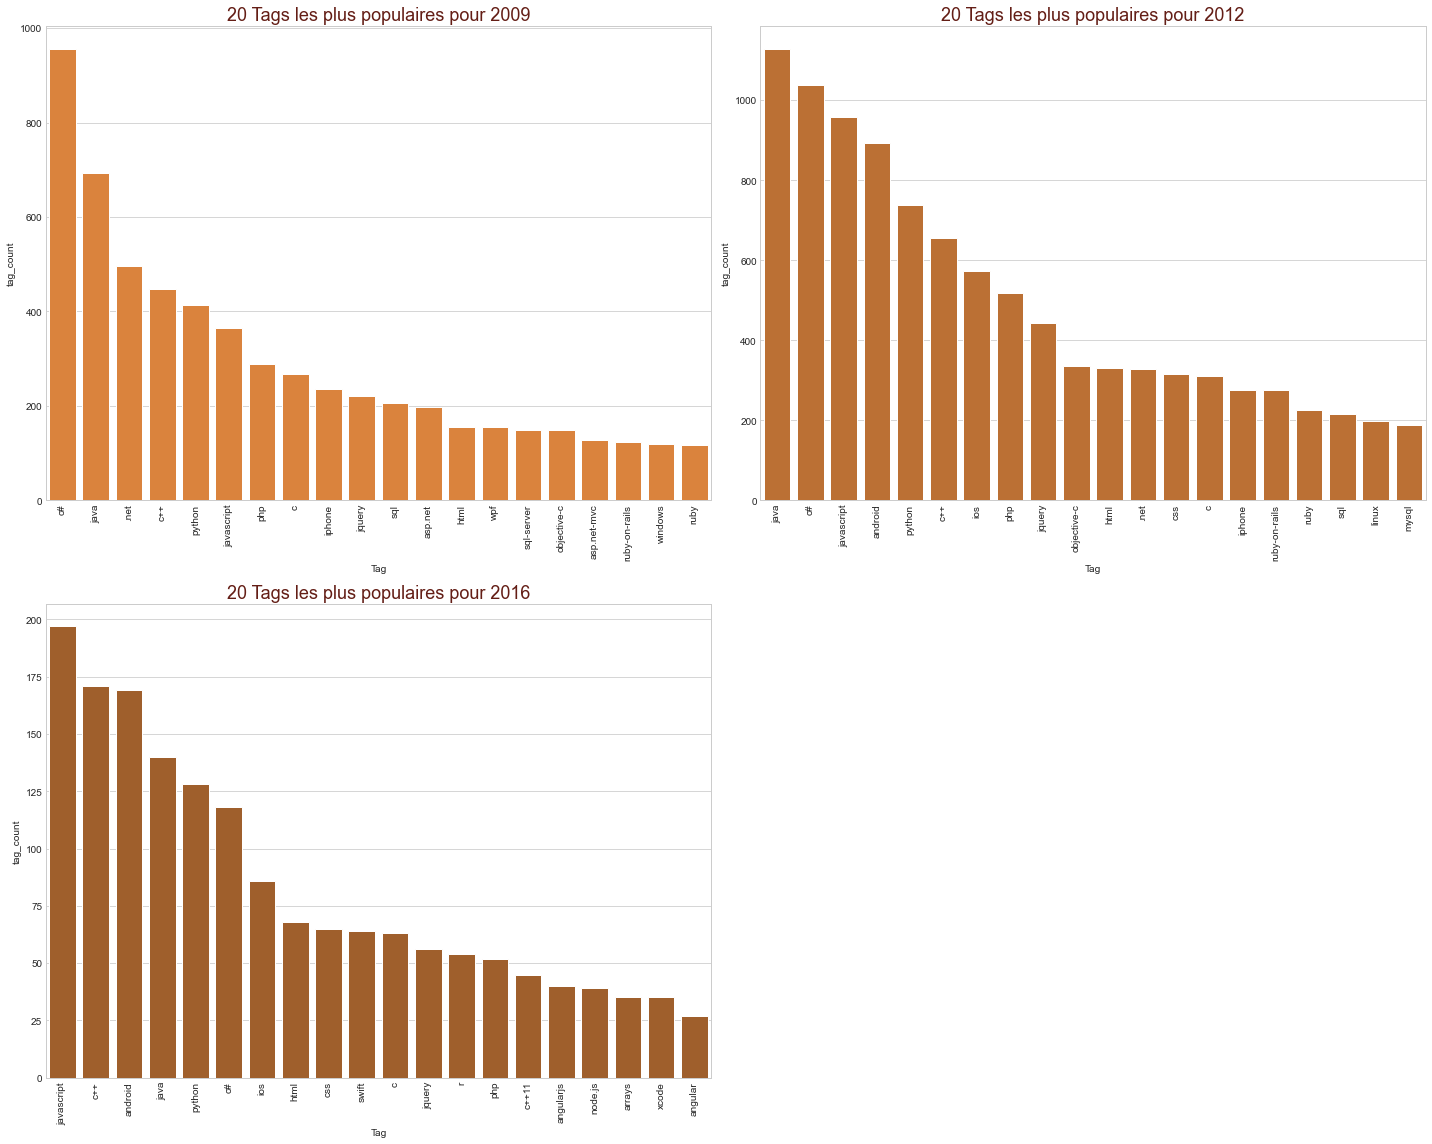

In [44]:
# Subplots parameters
years = {0: 2009, 1: 2012, 2: 2016}
colors = {0: "#f48023", 1: "#d16e1e",
          2: "#b25d19", 3: "#904b14"}
subplots = 3
cols = 2
rows = subplots // cols
rows += subplots % cols
position = range(1, subplots + 1)

# Plot popular tags for each year
fig = plt.figure(1, figsize=(20, 16))
for k in range(subplots):
    subset = data[data["CreationDate"].dt.year == years[k]]
    temp_list = count_split_tags(df=subset, column='Tags', separator=',')
    ax = fig.add_subplot(rows, cols, position[k])
    sns.barplot(data=temp_list.iloc[0:20, :],
            x=temp_list.iloc[0:20, :].index,
            y="tag_count", color=colors[k])
    plt.xticks(rotation=90)
    ax.set_title("20 Tags les plus populaires pour {}".format(years[k]),
                 fontsize=18, color="#641E16")

fig.tight_layout()
plt.show()

On remarque en effet que les centres d'intérêt évoluent en fonction des années. Cependant, on retrouve les principaux langages et framework informatiques dans les premières places.     

Nous allons a présent regarder le nombre de Tags par question :

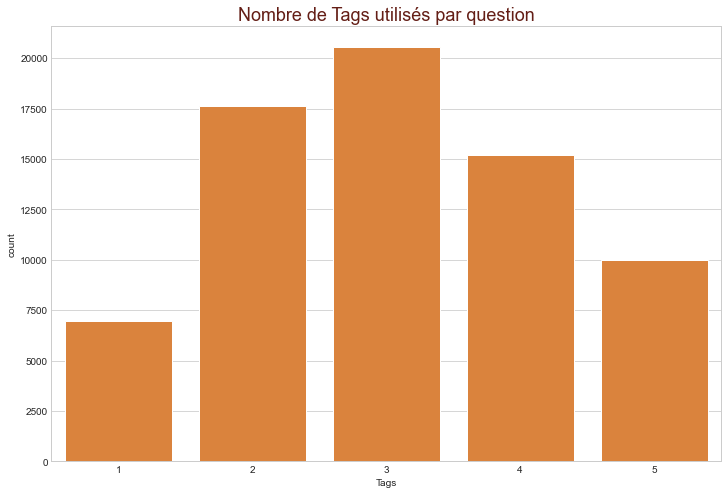

In [45]:
# Create a list of Tags and count the number
data['Tags_list'] = data['Tags'].str.split(',')
data['Tags_count'] = data['Tags_list'].apply(lambda x: len(x))

# Plot the result
fig = plt.figure(figsize=(12, 8))
ax = sns.countplot(x=data.Tags_count, color="#f48023")
ax.set_xlabel("Tags")
plt.title("Nombre de Tags utilisés par question",
          fontsize=18, color="#641E16")
plt.show()

Pour la majorité des questions StackOverflow analysées, 3 tags sont utilisés. Cela nous donne déjà une indication sur le type de modélisation à mettre en oeuvre.

### Filtrage du jeu de données avec les meilleurs Tags : 
Les process de NLP sont des algorithmes assez lents compte tenu de la quantité de données à traiter. Pour filtrer notre jeu de données, nous allons sélectionner toutes les questions qui comportent au minimum un des 50 meilleurs tags et supprimer les autres tags :

In [46]:
def filter_tag(x, top_list):
    """Comparison of the elements of 2 lists to 
    check if all the tags are found in a list of top tags.

    Parameters
    ----------------------------------------
    x : list
        List of tags to test.
    ----------------------------------------
    """
    temp_list = []
    for item in x:
        if (item in top_list):
            #x.remove(item)
            temp_list.append(item)
    return temp_list

In [47]:
top_tags = list(tags_list.iloc[0:50].index)
data['Tags_list'] = data['Tags_list']\
                    .apply(lambda x: filter_tag(x, top_tags))
data['number_of_tags'] = data['Tags_list'].apply(lambda x : len(x))
data = data[data.number_of_tags > 0]
print("Nouvelle taille du jeu de donnée : {} questions.".format(data.shape[0]))

Nouvelle taille du jeu de donnée : 53093 questions.


## Nettoyage des questions

Afin de traiter au mieux les données textuelles du Body, il est nécessaire de réaliser plusieurs tâches de data cleaning. Par exemple, le texte stocké dans cette variable est au format HTML. Nous allons donc supprimer toutes les balises HTML avec la librairie BeautifulSoup pour ne conserver que le texte brut.

Mais avant cette opération, nous allons supprimer tout le contenu placé entre 2 balises html, cela nous permettra de supprimer tout le code brut souvent copié dans les questions Stackoverflow et qui pourrait avoir un fort impact pour la suite.

In [48]:
print(data['Body'].head(3))

Id
120    <p>Has anyone got experience creating <strong>...
180    <p>This is something I've pseudo-solved many t...
260    <p>I have a little game written in C#. It uses...
Name: Body, dtype: object


In [56]:
def remove_code(x):
    """Function based on the Beautifulsoup library intended to replace 
    the content of all the <code> </code> tags of a text specified as a parameter.

    Parameters
    ----------------------------------------
    x : string
        Sequence of characters to modify.
    ----------------------------------------
    """
    soup = BeautifulSoup(x,"lxml")
    code_to_remove = soup.findAll("code")
    for code in code_to_remove:
        code.replace_with(" ")
    return str(soup)

In [57]:
start_time = time.time()
# Delete <code> in Body text
data['Body'] = data['Body'].apply(remove_code)
# Delete all html tags
data['Body'] = [BeautifulSoup(text,"lxml").get_text() for text in data['Body']]
exec_time = time.time() - start_time
print('-' * 50)
print("Execution time : {:.2f}s".format(exec_time))
print('-' * 50)
print(data['Body'].head(3))

--------------------------------------------------
Execution time : 42.70s
--------------------------------------------------
Id
120    Has anyone got experience creating SQL-based A...
180    This is something I've pseudo-solved many time...
260    I have a little game written in C#. It uses a ...
Name: Body, dtype: object


Nous allons ensuite vérifier si les textes des questions sont rédigés en plusieurs langues. Cela nous permettra de définir la liste des stop words à éliminer :

In [58]:
# Create feature "lang" with langdetect library
def detect_lang(x):
    try:
        return detect(x)
    except:
        pass

start_time = time.time()
data['short_body'] = data['Body'].apply(lambda x: x[0:100])
data['lang'] = data.short_body.apply(detect_lang)
exec_time = time.time() - start_time
print('-' * 50)
print("Execution time : {:.2f}s".format(exec_time))
print('-' * 50)

--------------------------------------------------
Execution time : 189.60s
--------------------------------------------------


In [59]:
# Count titles for each language
pd.DataFrame(data.lang.value_counts())

,lang
en,52993
fr,18
af,14
no,10
it,8
da,8
ro,3
ca,3
es,3
id,2


La langue Anglaise est très majoritairement représentée dans notre dataset. Nous allons donc supprimer de notre jeu de données tous les post dans une autre langue que l'anglais.

In [60]:
# Deletion of data that is not in the English language
data = data[data['lang']=='en']

Maintenant que nous avons un texte brut débarassé de ses balises HTML et du code, nous allons utiliser nltk.pos_tag pour identifier la nature de chaque mot du corpus afin de pouvoir ensuite conserver uniquement les noms. 
Nous allons créer une fonction qui sera appliquée dans un cleaner plus complet.

In [61]:
def remove_pos(nlp, x, pos_list):
    doc = nlp(x)
    list_text_row = []
    for token in doc:
        if(token.pos_ in pos_list):
            list_text_row.append(token.text)
    join_text_row = " ".join(list_text_row)
    join_text_row = join_text_row.lower().replace("c #", "c#")
    return join_text_row

Nous allons à présent réaliser plusieurs opérations de Text cleaning pour que nos données soient exploitables par les algorithmes de NLP :
- Suppression de tous les mots autres que les noms ;
- Mettre tout le texte en minuscules ;
- Supprimer les caractères Unicode (comme les Emojis par exemple) ;
- Suppression des espaces supplémentaires ;
- Suppression de la ponctuation ;
- Suppression des liens ;
- Supprimer les nombres.

In [62]:
data.head(5)

,CreationDate,Score,Title,Body,Tags,Tags_list,Tags_count,number_of_tags,short_body,lang
Id,,,,,,,,,,
120,2008-08-01 15:50:08+00:00,21,ASP.NET Site Maps,Has anyone got experience creating SQL-based A...,"sql,asp.net,sitema","[sql, asp.net]",3,2,Has anyone got experience creating SQL-based A...,en
180,2008-08-01 18:42:19+00:00,53,Function for creating color wheels,This is something I've pseudo-solved many time...,"algorithm,language-agnostic,colors,color-spac",[algorithm],4,1,This is something I've pseudo-solved many time...,en
260,2008-08-01 23:22:08+00:00,49,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...,"c#,.net,scripting,compiler-constructio","[c#, .net]",4,2,I have a little game written in C#. It uses a ...,en
330,2008-08-02 02:51:36+00:00,29,Should I use nested classes in this case?,I am working on a collection of classes used f...,"c++,oop,class,nested-clas",[c++],4,1,I am working on a collection of classes used f...,en
470,2008-08-02 15:11:47+00:00,13,Homegrown consumption of web services,I've been writing a few web services for a .ne...,".net,web-service",[.net],2,1,I've been writing a few web services for a .ne...,en


In [63]:
def text_cleaner(x, nlp, pos_list):
    """Function allowing to carry out the preprossessing on the textual data. 
        It allows you to remove extra spaces, unicode characters, 
        English contractions, links, punctuation and numbers.
        
        The re library for using regular expressions must be loaded beforehand.

    Parameters
    ----------------------------------------
    x : string
        Sequence of characters to modify.
    ----------------------------------------
    """
    # Remove POS not in "NOUN", "PROPN"
    x = remove_pos(nlp, x, pos_list)
    # Case normalization
    x = x.lower()
    # Remove unicode characters
    x = x.encode("ascii", "ignore").decode()
    # Remove English contractions
    x = re.sub("\'\w+", '', x)
    # Remove ponctuation but not # (for C# for example)
    x = re.sub('[^\\w\\s#]', '', x)
    # Remove links
    x = re.sub(r'http*\S+', '', x)
    # Remove numbers
    x = re.sub(r'\w*\d+\w*', '', x)
    # Remove extra spaces
    x = re.sub('\s+', ' ', x)
    
    # Return cleaned text
    return x

In [68]:
# Apply cleaner on Body
# Spacy features
nlp = spacy.load('en_core_web_sm')
pos_list = ["NOUN","PROPN"]

start_time = time.time()
print('-' * 50)
print("Start Body cleaning ...")
print('-' * 50)

tqdm.pandas()
data['Body_cleaned'] = ''
#data['Body_cleaned'] = data.Body.progress_apply(lambda x : text_cleaner(x, nlp, pos_list))
for i in data.index :
    data['Body_cleaned'][i] = text_cleaner(data['Body'][i], nlp, pos_list)

exec_time = time.time() - start_time
print("Execution time : {:.2f}s".format(exec_time))
print('-' * 50)
print(data['Body_cleaned'].head(3))

--------------------------------------------------
Start Body cleaning ...
--------------------------------------------------


<ipython-input-68-80cb1fada1a7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Body_cleaned'][i] = text_cleaner(data['Body'][i], nlp, pos_list)
  0%|          | 0/52993 [06:38<?, ?it/s]


Execution time : 831.20s
--------------------------------------------------
Id
120    experience sql site map providers default xml ...
180    pseudo times solution problem way colors param...
260    game c# database end trading card game functio...
Name: Body_cleaned, dtype: object


Nous pouvons à présent supprimer tous les stop words en langue Anglaise grâce à la librairie NLTK. Avant cette étape, nous allons réaliser une tockenisation, c'est à dire découper les phrases en mots et création d'une liste (chaque phrase est une liste de mots).

In [69]:
start_time = time.time()
# Tockenization
data['Body_cleaned'] = data.Body_cleaned.apply(nltk.tokenize.word_tokenize)

# List of stop words in "EN" from NLTK
stop_words = stopwords.words("english")

# Remove stop words
data['Body_cleaned'] = data.Body_cleaned\
    .apply(lambda x : [word for word in x
                       if word not in stop_words
                       and len(word)>2])
exec_time = time.time() - start_time
print('-' * 50)
print("Execution time : {:.2f}s".format(exec_time))
print('-' * 50)
print(data['Body_cleaned'].head(3))

--------------------------------------------------
Execution time : 9.64s
--------------------------------------------------
Id
120    [experience, sql, site, map, providers, defaul...
180    [pseudo, times, solution, problem, way, colors...
260    [game, database, end, trading, card, game, fun...
Name: Body_cleaned, dtype: object


A présent, nous avons des listes de mots débarrassées des mots courants (stop words), de la ponctuation, des liens et des nombres. Une dernière étape que nous pouvons effectuer est la Lemmatisation. Ce procédé consiste à prendre le mot à sa forme racine appelée Lemme. Cela nous permet d'amener les mots à leur forme "dictionnaire". Nous allons pour cela utiliser à nouveau la librairie NLTK.

In [70]:
# Apply lemmatizer on Body
start_time = time.time()
wn = WordNetLemmatizer()
data['Body_cleaned'] = data.Body_cleaned\
    .apply(lambda x : [wn.lemmatize(word) for word in x])
exec_time = time.time() - start_time
print('-' * 50)
print("Execution time : {:.2f}s".format(exec_time))
print('-' * 50)
print(data['Body_cleaned'].head(3))

--------------------------------------------------
Execution time : 4.87s
--------------------------------------------------
Id
120    [experience, sql, site, map, provider, default...
180    [pseudo, time, solution, problem, way, color, ...
260    [game, database, end, trading, card, game, fun...
Name: Body_cleaned, dtype: object


Le corps de texte étant nettoyé, nous allons regarder la répartition de la "taille des corpus" dans le jeu de données :

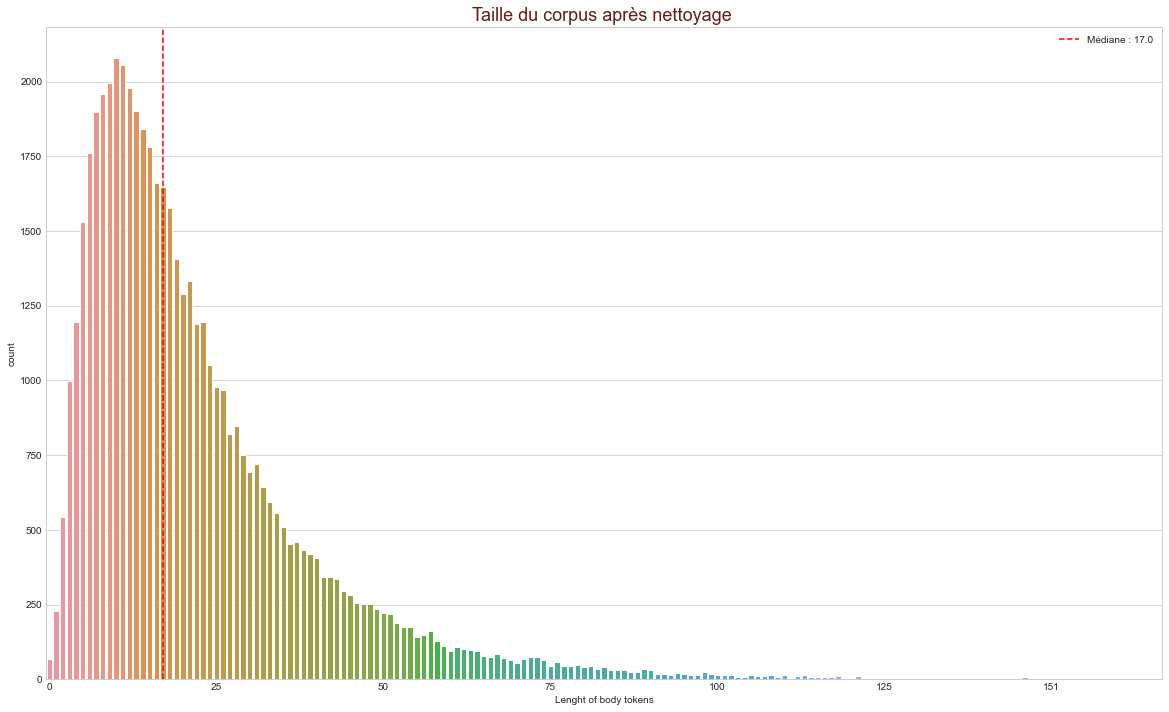

In [71]:
# Calculate lenght of each list in Body
data['body_tokens_count'] = [len(_) for _ in data.Body_cleaned]

# Countplot of body lenght
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=data.body_tokens_count)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 25))
plot_median = data.body_tokens_count.median()
plt.axvline(plot_median - data.body_tokens_count.min(),
            color="r", linestyle='--',
            label="Médiane : "+str(plot_median))
ax.set_xlabel("Lenght of body tokens")
plt.title("Taille du corpus après nettoyage ",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

Nous allons également regarder les fréquences de chaque mots de la variable Body pour visualiser les plus représentés :

In [72]:
# Create a list of all tokens for Body
full_corpus = []
for i in data['Body_cleaned']:
    full_corpus.extend(i)

In [73]:
# Calculate distribition of words in Body token list
body_dist = nltk.FreqDist(full_corpus)
body_dist = pd.DataFrame(body_dist.most_common(2000),
                         columns=['Word', 'Frequency'])
body_dist.describe()

,Frequency
count,2000.000000
mean,519.208000
std,1319.616193
min,45.000000
25%,72.000000
50%,136.000000
75%,363.000000
max,21808.000000


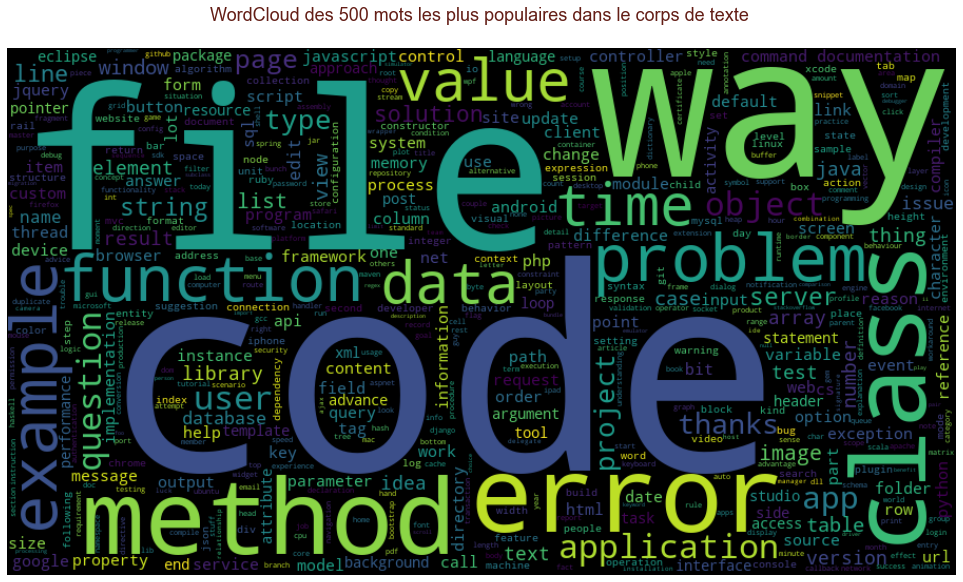

In [74]:
# Plot word cloud with tags_list (frequencies)
fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(body_dist.set_index('Word').to_dict()['Frequency'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("WordCloud des 500 mots les plus populaires dans le corps de texte \n",
          fontsize=18, color="#641E16")
plt.show()

## Nettoyage des titres
Nous avons préalablement défini une fonction pour notre cleaning des Body. Nous allons la modifier pour y intégrer la tokenisation, les stop words et la lemmanisation afin d'obtenir un processus complet à appliquer aux titres des posts.

In [75]:
def text_cleaner(x, nlp, pos_list, lang="english"):
    """Function allowing to carry out the preprossessing on the textual data. 
        It allows you to remove extra spaces, unicode characters, 
        English contractions, links, punctuation and numbers.
        
        The re library for using regular expressions must be loaded beforehand.
        The SpaCy and NLTK librairies must be loaded too. 

    Parameters
    ----------------------------------------
    x : string
        Sequence of characters to modify.
    ----------------------------------------
    """
    # Remove POS not in "NOUN", "PROPN"
    x = remove_pos(nlp, x, pos_list)
    # Case normalization
    x = x.lower()
    # Remove unicode characters
    x = x.encode("ascii", "ignore").decode()
    # Remove English contractions
    x = re.sub("\'\w+", '', x)
    # Remove ponctuation but not # (for C# for example)
    x = re.sub('[^\\w\\s#]', '', x)
    # Remove links
    x = re.sub(r'http*\S+', '', x)
    # Remove numbers
    x = re.sub(r'\w*\d+\w*', '', x)
    # Remove extra spaces
    x = re.sub('\s+', ' ', x)
        
    # Tokenization
    x = nltk.tokenize.word_tokenize(x)
    # List of stop words in select language from NLTK
    stop_words = stopwords.words(lang)
    # Remove stop words
    x = [word for word in x if word not in stop_words 
         and len(word)>2]
    # Lemmatizer
    wn = nltk.WordNetLemmatizer()
    x = [wn.lemmatize(word) for word in x]
    
    # Return cleaned text
    return x

In [76]:
# Spacy features
nlp = spacy.load('en_core_web_sm')

pos_list = ["NOUN","PROPN"]
# Apply full cleaner on Title
print('-' * 50)
print("Start Title cleaning ...")
print('-' * 50)
start_time = time.time()

data['Title_cleaned'] = ''
for i in data.index :
    data['Title_cleaned'][i] = text_cleaner(data['Title'][i], nlp, pos_list, "english")

#data['Title_cleaned'] = data.Title\
#                            .progress_apply(lambda x: 
#                                            text_cleaner(x,
#                                                         nlp,
#                                                         pos_list,
#                                                         "english"))

exec_time = time.time() - start_time
print("Execution time : {:.2f}s".format(exec_time))
print('-' * 50)
print(data['Title_cleaned'].head(3))

--------------------------------------------------
Start Title cleaning ...
--------------------------------------------------


<ipython-input-76-37337874f7e1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Title_cleaned'][i] = text_cleaner(data['Title'][i], nlp, pos_list, "english")


Execution time : 283.01s
--------------------------------------------------
Id
120                             [aspnet, site, map]
180                        [function, color, wheel]
260    [scripting, functionality, net, application]
Name: Title_cleaned, dtype: object


Nous pouvons à présent projeter la distribution de la taille des tokens Title et le nuage de mots correspondant aux 500 meilleurs apparitions : 

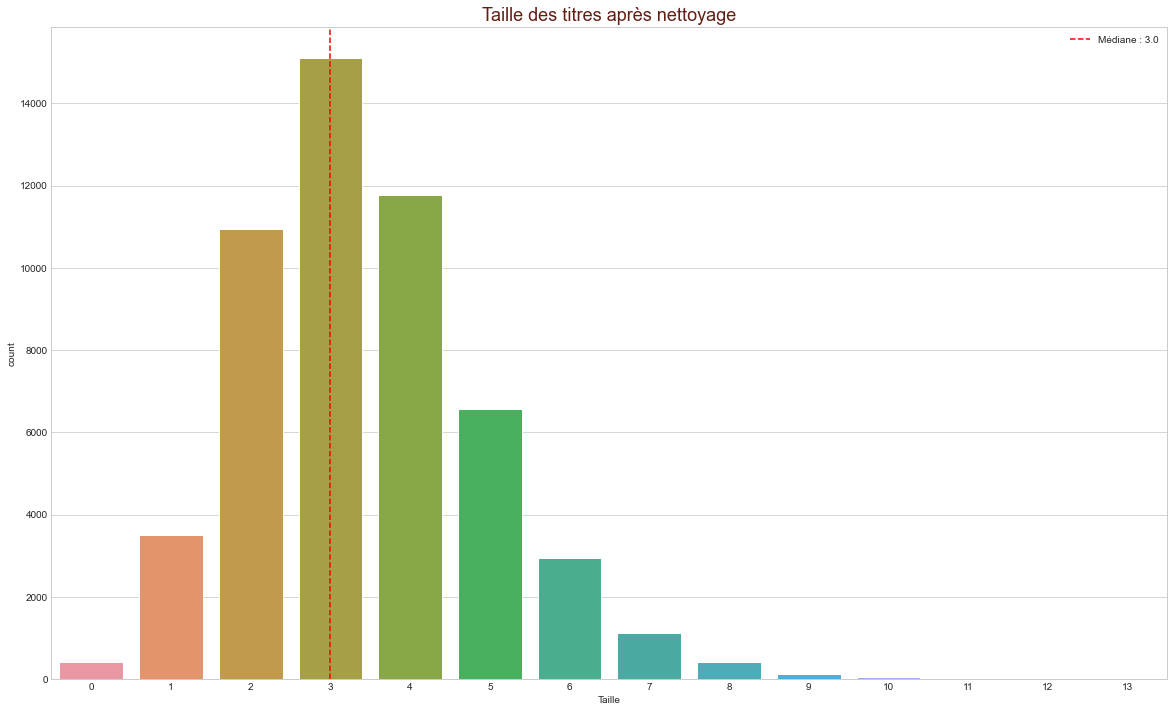

In [77]:
# Calculate lenght of each list in Body
data['Title_tokens_count'] = [len(_) for _ in data.Title_cleaned]

# Countplot of body lenght
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=data.Title_tokens_count)
median_plot = data.Title_tokens_count.median()
plt.axvline(median_plot - data.Title_tokens_count.min(),
            color="r", linestyle='--',
            label="Médiane : "+str(median_plot))
ax.set_xlabel("Taille")
plt.title("Taille des titres après nettoyage",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

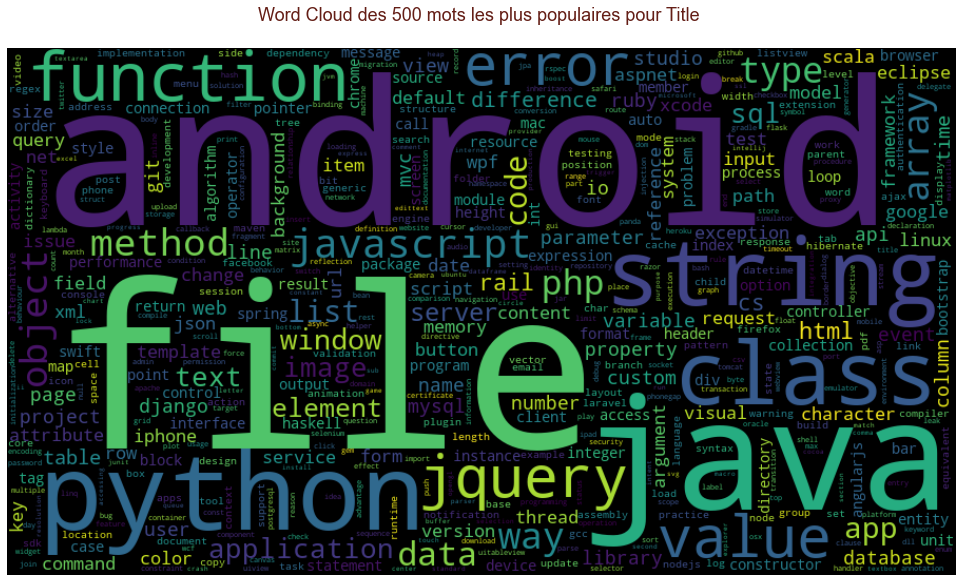

In [78]:
# Create a list of all tokens for Title
full_corpus_t = []
for i in data['Title_cleaned']:
    full_corpus_t.extend(i)

# Calculate distribition of words in Title token list
title_dist = nltk.FreqDist(full_corpus_t)
title_dist = pd.DataFrame(title_dist.most_common(500),
                          columns=['Word', 'Frequency'])

# Plot word cloud with tags_list (frequencies)
fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(title_dist.set_index('Word').to_dict()['Frequency'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud des 500 mots les plus populaires pour Title \n",
          fontsize=18, color="#641E16")
plt.show()

## Export du dataset nettoyé
Nous pouvons maintenant supprimer les variables créées pour l'analyse exploratoire, qui ne nous seront plus utiles, et exporter le dataset pour nos modélisations supervisées et non supervisées.

Enfin, afin d'avoir suffisamment de "matière" pour alimenter nos algorithmes de prédiction de Tags, nous allons conserver uniquement les questions qui comptent au minimum 5 tokens dans la variable Body.

In [79]:
# Delete items with number of Body tokens < 5
data = data[(data.body_tokens_count >= 5) & (data.Title_tokens_count > 0)]
# Remove calculated features
data = data[['Title_cleaned',
             'Body_cleaned',
             'Score',
             'Tags_list']]
# Rename columns
data = data.rename(columns={'Title_cleaned': 'Title',
                            'Body_cleaned': 'Body',
                            'Tags_list': 'Tags'})
data.head(3)

,Title,Body,Score,Tags
Id,,,,
120,"[aspnet, site, map]","[experience, sql, site, map, provider, default...",21,"[sql, asp.net]"
180,"[function, color, wheel]","[pseudo, time, solution, problem, way, color, ...",53,[algorithm]
260,"[scripting, functionality, net, application]","[game, database, end, trading, card, game, fun...",49,"[c#, .net]"


In [80]:
# Export to CSV
data.to_csv("StackOverflow_questions_2009_2020_cleaned.csv", sep=";")